# A combinatorial optimization framework for probability-based algorithms by means of generative models 💻📈⚡

This notebook showcases two examples of the Python 🐍 library developed for the paper *A combinatorial optimization framework for probability-based algorithms by means of generative models*.

The repository of the project is available in [SourceHut](https://git.sr.ht/~mikelma/nnco_lib) and in [GitHub](https://github.com/mikelma/nnco_lib) (mirror).


> ⚠️ **Quick note:**  The objective of this document is to illustrate practical usage of the ideas developed in the paper, and it assumes (at some degree) that the user had a look at the paper. Feel free to email me (first author of the paper) if you have any questions!

## Dependencies

First of all, let's clone the project's repository and build it's dependencies. This might take a few minutes to complete, as some dependencies have to be compiled from source.

> **⚠️ NOTE**: If you are running this notebook on your own machine, please make sure that you have  
[Rust](https://www.rust-lang.org/learn/get-started)
 and [PyTorch](https://pytorch.org/get-started/locally/) installed.

*The nnco_lib repository provides:*
- A Python library implementing the optimization framework proposed in the paper.
- The set of optimization instances used in the paper (LOP and PFSP).
- The `pypermu` python library: fast implementation of common permutation operations and problems (uses the Rust programming language).

In [1]:
#@title Dependency installation & building
# install build dependencies
!apt install cargo
# clone project's repo
!git clone --recurse-submodules https://git.sr.ht/~mikelma/nnco_lib
# change notebook's cwd
%cd nnco_lib
# build pypermu libarary
!cd pypermu && cargo b --release && mv target/release/libpypermu.so ../pypermu.so
# unzip LOP instances
!mkdir -p all_instances/{LOP,PFSP} && cd all_instances/LOP && unzip -q ../../instances/LOP/IO.zip && cd ../PFSP && unzip -q ../../instances/PFSP/PFSP.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libstd-rust-1.75 libstd-rust-dev rustc
Suggested packages:
  cargo-doc llvm-17 lld-17 clang-17
The following NEW packages will be installed:
  cargo libstd-rust-1.75 libstd-rust-dev rustc
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 98.1 MB of archives.
After this operation, 392 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstd-rust-1.75 amd64 1.75.0+dfsg0ubuntu1~bpo0-0ubuntu0.22.04 [46.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstd-rust-dev amd64 1.75.0+dfsg0ubuntu1~bpo0-0ubuntu0.22.04 [41.6 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 rustc amd64 1.75.0+dfsg0ubuntu1~bpo0-0ubuntu0.22.04 [3,404 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 cargo amd64 1.75.0+dfsg0ubu

## Optimization of a LOP instance

In this section, we'll use the optimization framework introduced in the paper to optimize a LOP instance.

The next code block loads all the necessary modules and data needed to run this example. Note that the only Python requirements are [PyTorch](https://pytorch.org/) and [`nnco_lib`](https://git.sr.ht/~mikelma/nnco_lib).

In [2]:
import torch
from torch.optim import Adam
import torch.nn as nn
import numpy as np

# libraries included in the `nnco_lib`  repository
from nnco.pl import PLHead
from nnco import utility
from pypermu import problems

Now, detect if there's a GPU available. GPUs highly increase the optimization speed of the algorithm, but for the simple examples provided in this notebook, a GPU card isn't mandatory.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Let's select the path where the LOP instance to optimize is located. The size of the instance has also been specified for later usage.

In [19]:
instance = "all_instances/LOP/N-be75eec"
size = 50

problem = problems.lop.Lop(instance)

Define the hyperparameters of the algorithm. The selected ones are some sane defaults, but feel free to play with the values!

In [5]:
# Number of solutions sampled per iteration from the probability distribution
# over the solution space of the problem.
num_samples = 64

# Dimension of the noise vector: the input to the generative model.
noise_dim = 128

# Same as the usual batch size and learning rate in ML.
batch_size = 32
learning_rate = 0.003

We'll follow the same stopping criterion as in the paper: the number of solutions that the algorithm can evaluate is limited as:
<br> <br>

following the paper,

$
\text{max_evals} = 1000n^2
$,

consequently,

$
\text{max_iters} = \frac{\text{max_evals}}{\text{batch_size} * \text{num_samples}}
$


In [11]:
max_evals = 1000*size**2
num_iters = int(max_evals/(batch_size*num_samples))

print("* Maximum solution evaluations:", max_evals)
print("* Total number of iterations:  ", num_iters)

* Maximum solution evaluations: 2500000
* Total number of iterations:   1220


### Defining the generative model

Now we'll define the PyTorch model corresponding to the generative model used in the paper. Again, feel free to play with different NN architectures, but be sure to always set the input size equal to the dimension of the noise vector (`noise_dim`) and the output shape to: `num_samples` $\times$ `sample_size`.

> ℹ️ The last layer of the model, [`PLHead`](https://git.sr.ht/~mikelma/nnco_lib/tree/main/item/nnco/pl.py), is a custom module from the `nnco_lib` library. Given an input vector, `PLHead` feeds the vector to a [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer. Then, its the resulting values are used to parametrize a Plackett-Luce (PL) probability distribution. Finally, the PL distribution gets sampled generating a set of new solutions. These solutions together with their log probabilities and the used logits are returned.

In [22]:
model = nn.Sequential(
            ## for example, you can uncomment the two lines below to add an
            ## extra layer to the generative model

            # torch.nn.Linear(noise_dim, noise_dim),
            # torch.nn.ReLU(),

            PLHead(
                input_dim=noise_dim,
                sample_length=size,
                num_samples=num_samples,
                device=device,
            ),
        ).to(device)
model

Sequential(
  (0): PLHead(
    (linear): Linear(in_features=128, out_features=50, bias=True)
  )
)

Initialize the optimizer for the generative model. In this case, we employ the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) algorithm (same as in the paper), but [other algorithms](https://pytorch.org/docs/stable/optim.html) can be used too.

In [23]:
optimizer = Adam(model.parameters(), lr=learning_rate)

### Main loop

Before getting into the interesting part, let's create a simple function that will help us track the progress of the optimization process. This function just saves some training statistics and prints some relevant information, such as the mean fitness of the current samples and the value of the loss function.

In [13]:
best_fitness, avg_fitness, std_fitness, min_fitness, max_fitness = [], [], [], [], []

def logger(fitness_lst, iter, max_iters, loss, is_minim=False):
    val_max = fitness_lst.max().item()
    if len(best_fitness) == 0 or (val_max > best_fitness[-1] and not is_minim) or (val_max < best_fitness[-1] and is_minim):
        best_fitness.append(val_max)
    else:
        best_fitness.append(best_fitness[-1])
    avg_fitness.append(fitness_lst.mean().item())
    std_fitness.append(fitness_lst.std().item())
    min_fitness.append(fitness_lst.min().item())
    max_fitness.append(fitness_lst.max().item())
    print(f'{iter}/{max_iters} loss: {loss.item()}, mean: {fitness_lst.mean()}, \
best: {best_fitness[-1]}')


The next block holds the main loop of the algorithm. Run it to start optimizing! ⚡

The description of the steps followed by the code block are the following:

1. Sample a set $\mathcal{Z}$ of input vectors $\mathbf{z}$ from a normal distribution:
$$\mathcal{Z} = \{ \mathbf{z}^i | \mathbf{z}^i_j \sim \mathcal{N}(0, 1), j=1,\ldots,m\}_{i=1,\ldots,\tau}$$

2. Sample a set of solutions $\mathcal{D}^{\mathbf{z}}$ for each input vector $\mathbf{z}$,
$$~{\mathcal{D}^{\mathbf z} = \{ \mathbf{x}^{i, \mathbf z} | \mathbf{x}^i \sim P_\theta(\mathbf x | \mathbf z) \}_{i=1,\ldots,\lambda}}$$

3. Compute the objective function value $f(\mathbf{x})$ of each solution $\mathbf{x}$.

4. Standardize the objective function values obtained in the previous step.

5. Compute the loss function value and the gradient estimate $d_t$:
$$
d_t = \frac{1}{\tau\lambda} \sum_{\mathbf z \in \mathcal{Z}} \sum_{\mathbf x \in \mathcal{D}^{\mathbf z}}\nabla_\theta \log(P_\theta (\mathbf x| \mathbf z))f(\mathbf x)
$$
<br>And update the parameters $\theta$ of the generative model $g_\theta$ as, $$\theta_{t+1} \gets \theta_t - \alpha d_t$$





In [25]:
for iter in range(num_iters):
    # (1)
    z = torch.normal(mean=0, std=1,
                     size=(batch_size, noise_dim), device=device)

    # (2)
    print(z)
    print(next(model.parameters()).device)
    samples, logps, _logits = model(z)

    # (3)
    fitness = [problem.evaluate(batch) for batch in samples.cpu().numpy()]
    fitness = torch.as_tensor(fitness, dtype=torch.float32, device=device)

    # (4)
    u = utility.standarized_utility(fitness)

    # (5)
    loss = -(logps * u).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    logger(fitness, iter, num_iters, loss)

print(f'Best objective function value: {best_fitness[-1]}')

Streaming output truncated to the last 5000 lines.
        [ 0.2578, -0.0289,  1.0856,  ...,  1.0292, -1.6848,  0.7267],
        [-1.2132, -1.7152,  2.2321,  ...,  1.0589,  0.4254, -0.1038],
        [ 0.3350,  0.1856,  0.1371,  ...,  1.0008,  1.2185, -0.2698]],
       device='cuda:0')
cuda:0
30/1220 loss: -0.22805166244506836, mean: 126340.6875, best: 195071.0
tensor([[-0.7658,  1.5781,  1.0075,  ..., -0.4267, -1.1878,  2.5214],
        [-2.3392, -0.8703, -0.4999,  ..., -0.2139,  3.1585, -0.7874],
        [-1.7499,  0.8479, -0.7195,  ..., -0.3315, -0.0738, -0.0676],
        ...,
        [ 0.3120,  0.4605, -0.4477,  ...,  0.0638, -0.2284, -0.6407],
        [ 0.5078, -0.2983, -0.2730,  ...,  0.4892,  0.3856, -0.7903],
        [-0.3412,  0.9964, -0.8017,  ...,  0.5764,  0.5037, -0.7869]],
       device='cuda:0')
cuda:0
31/1220 loss: -0.33230048418045044, mean: 127417.34375, best: 195071.0
tensor([[-0.3726, -0.7091, -2.0233,  ..., -0.5593, -1.4272,  1.1683],
        [-0.0891,  0.7289,  0.5

KeyboardInterrupt: 

### Result visualization

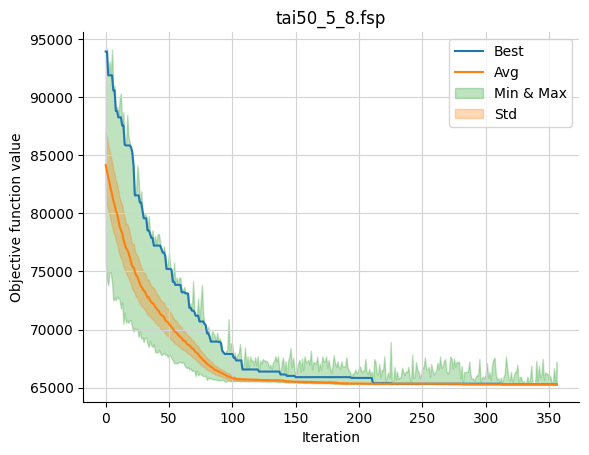

In [16]:
import matplotlib.pyplot as plt

def plot_results():
    plt.grid(True, color="lightgrey")

    plt.plot(best_fitness, label="Best", c="tab:blue")
    plt.plot(avg_fitness, label="Avg", c="tab:orange")

    s, y = np.array(std_fitness), np.array(avg_fitness)

    fmin = np.array(min_fitness)
    fmax = np.array(max_fitness)

    plt.fill_between(range(len(s)), fmin, fmax,
                     color="tab:green", alpha=0.3,
                     label="Min & Max")

    plt.fill_between(range(len(s)), y - s, y + s,
                     color="tab:orange", alpha=0.3,
                     label="Std")

    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.title(instance.split('/')[-1])
    plt.legend()
    plt.show()

plot_results()

## Optimizing a PFSP instance

The flexibility of the presented framework allows the optimization of different combinatorial problems with minimal changes to the implementation. To illustrate this, in this section, we'll focus on a very different CO problem, the PFSP.
<br>

Like in the LOP example, the first step will be to load the instance that we want to optimize. Note that the new instance has the same size as the one in the previous example, $n=50$, so we don't need to compute the maximum number of iterations again.

In [8]:
instance = "all_instances/PFSP/tai50_5_8.fsp"
problem = problems.pfsp.Pfsp(instance)

### The generative model

When optimizing the LOP, we used the *Plackett-Luce* probability distribution.  Following the paper, we'll use the *Univariate Marginals Distribution* (UMD) for the PFSP.

Correspondingly, we have to change the generative model to output the parameters of the UMD instead of those of a PL distribution.

> ℹ️ Note that the last layer of the model is [`UMDHead`](https://git.sr.ht/~mikelma/nnco_lib/tree/main/item/nnco/umd.py), implemented in `nnco_lib`. The layer follows the same procedure as `PLHead` only using a UMD distribution instead of the PL one.

> ℹ️ [`LinearParallel`](https://git.sr.ht/~mikelma/nnco_lib/tree/main/item/nnco/umd.py) is another layer that given an input vector(s), runs the input through $n$ linear layers, returning the generated $n$ output vectors. See Figure 2.a of the paper, specifically the intermediate layers of the shown architecture.

In [9]:
from nnco.umd import UMDHead, LinearParallel
model = nn.Sequential(
            ## it's possible to replace the `LinearParallel` layer with a
            ## standard Linear layer.

            # torch.nn.Linear(noise_dim, noise_dim),
            # torch.nn.ReLU(),

            LinearParallel(
                in_dim=noise_dim,
                out_dim=noise_dim,
                num_linears=size,
                activation=nn.ReLU()),
            UMDHead(
                input_dim=noise_dim,
                sample_length=size,
                num_samples=num_samples,
                device=device,
            )
        ).to(device)

# generate an optimizer for the new model
optimizer = Adam(model.parameters(), lr=learning_rate)

### The main loop

There are two changes to the implementation of the LOP example:

1. Instead of directly evaluating the sampled solutions (see 3rd step in the block below),  we evaluate their inverse permutations (refer to the paper for more information). In summary, we replace $f(\sigma)$ with $f(\sigma^{-1})$.

2. In the LOP example, there was a minus sign in front of the loss function (see 4th step). For the PFSP the minus sign has been removed, as the LOP is a maximization problem and the PFSP is a minimization one. Again, refer to the paper for more information.

In [14]:
from pypermu import utils as permutils

# restart the list used by the `logger` function
best_fitness, avg_fitness, std_fitness = [], [], []

for iter in range(num_iters):
    # (1)
    z = torch.normal(mean=0, std=1,
                     size=(batch_size, noise_dim), device=device)

    # (2)
    samples, logps, _logits = model(z)

    # (3)
    permus = [permutils.transformations.marina2permu(b) for b in samples.cpu().numpy()]
    permus = [permutils.transformations.permu2inverse(batch) for batch in permus]

    fitness = [problem.evaluate(batch) for batch in permus]
    fitness = torch.as_tensor(fitness, dtype=torch.float32, device=device)

    # (4)
    u = utility.standarized_utility(fitness)

    # (5)
    loss = (logps * u).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    logger(fitness, iter, num_iters, loss, is_minim=True)

print(f'Best objective function value: {best_fitness[-1]}')

0/1220 loss: -0.2352294921875, mean: 84153.46875, best: 93928.0
1/1220 loss: -0.3774747848510742, mean: 83620.671875, best: 93928.0
2/1220 loss: -0.5676294565200806, mean: 83109.53125, best: 91882.0
3/1220 loss: -0.7176204919815063, mean: 82672.765625, best: 91882.0
4/1220 loss: -0.8038333058357239, mean: 82089.03125, best: 91882.0
5/1220 loss: -1.0292401313781738, mean: 81647.71875, best: 91882.0
6/1220 loss: -1.121512770652771, mean: 81115.640625, best: 90583.0
7/1220 loss: -1.2800467014312744, mean: 80782.1171875, best: 90583.0
8/1220 loss: -1.3976125717163086, mean: 80238.0390625, best: 88811.0
9/1220 loss: -1.561394214630127, mean: 79955.078125, best: 88811.0
10/1220 loss: -1.7219054698944092, mean: 79441.4296875, best: 88265.0
11/1220 loss: -1.820943832397461, mean: 78869.3515625, best: 88265.0
12/1220 loss: -1.7843859195709229, mean: 78581.3984375, best: 88265.0
13/1220 loss: -1.9683024883270264, mean: 78304.421875, best: 87574.0
14/1220 loss: -2.0775914192199707, mean: 77765.82

KeyboardInterrupt: 

### Visualizing the results

In [15]:
plot_results()

NameError: name 'plot_results' is not defined